In [1]:
import os
import sys
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

## set up paths, model parameters, and grab data

First, grab data directories, note: test_dir will contain the labeled data and training_dir needs to be entirely unlabeled

In [2]:
data_dir = './../fourthbrain-capstone/data/raw/OCT2017/'
test_dir = data_dir + "test/"
training_dir = data_dir + 'unlabeled_data_20k_images'

After we have our directories, we can run `data_utils` and use the `prepare_dataset` udf. This will call the necessary `image_dataset_from_directory` commands for the unlabeled and labeled datasets.<br> **Note**: test_data, which is 1000 images, will have 1000 images and be broken down into a validation and a test dataset (usually at 20%, 80% respectively). 


We define some parameters below: 

`width` is utilized in the RNN - this can be thought of as the max width of the final dense layer, as well as some layers within the teacher net

`temperature` is used in the contrastive loss function for scaling, this helps it learn from 'hard negatives' 


**Augmentation**: Stronger augmentations for contrastive, weaker ones for supervised training

**jitter' refers to the color scaling, **brightness** refers to strength of contrast, **min_area** related to cropping.

In [5]:
image_size = 224
image_channels = 3
num_epochs = 100
batch_size = 32 
width = 128 
temperature = 0.1 
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2} 
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [3]:
# add the project dir to sys.path in order to access modules for import
sys.path.append(os.path.dirname(os.getcwd()))

from src.utils.data_utils import prepare_dataset

In [4]:
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset(training_dir,
                    test_dir,
                    image_size=image_size,
                    batch_size=batch_size,
                    seed = 1234,
                    val_split = 0.2)

#below we see in the output that 20k images belong to 1 class - this is because they are UNLABELED 

Found 20000 files belonging to 1 classes.
Found 1000 files belonging to 4 classes.
Using 800 files for training.
Found 1000 files belonging to 4 classes.
Using 200 files for validation.


2022-06-24 17:09:46.099076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Image augmentations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


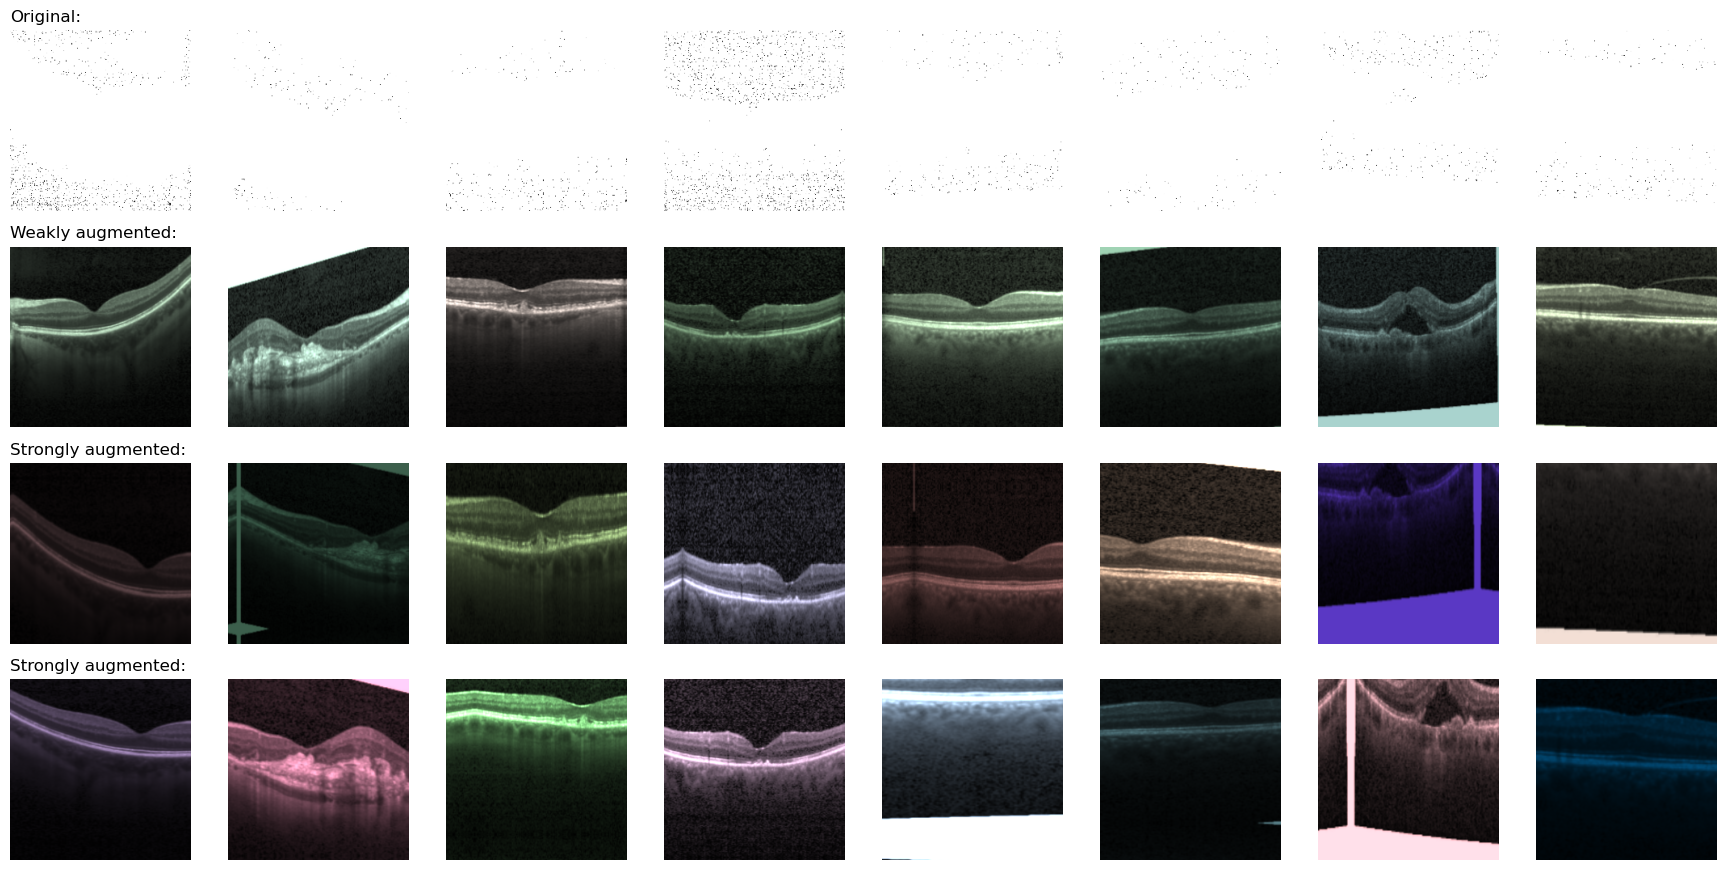

In [6]:
#Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        """Get config from input, this is the args in the previous cell"""
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        """call function utilized in keras.model setup and informs how to utilize RAndomColorAffine class
        note: No test step, only called in training"""
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    """get_augmentor reads in configs and then applies pixel scaling, 
    image augmentation through flipping/cropping, and RandomColorAffine"""
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    """visualization augmentations reads in a number of images and applies the augmentation at various strengths. 
    This is then plotted so the user can get a feel of how the images are being processed"""
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

## encoder architecture

In [7]:
# Define the encoder architecture

#call down resnet50, specifiy the input shape, and take away the weights/top
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(image_size, image_size, image_channels))

def get_resnet_encoder(resnet, data, image_size, image_channels, width):
    """set up the get_resnet_encoder. 
    This model architecture will be used in the teacher net and passed to the student net
    
    Note: The output of this net has a FC layer with a relu activation and is of width nodes. 
    This gets passed into the linear probe or the projection heads of the teacher net and the FC layer of width number of classes for the student net"""
    image_batch, _ = next(iter(data))
    feature_batch = resnet(image_batch)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense = layers.Dense(width, activation = 'relu')
    
    inputs = tf.keras.Input(shape = (image_size, image_size, image_channels))
    x = resnet(inputs)
    x = global_average_layer(x)
    outputs = dense(x)
    encoder = keras.Model(inputs, outputs)
    return encoder

In [8]:
get_resnet_encoder(resnet50,labeled_train_dataset,image_size, image_channels, width).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________


## Supervised baseline model
Baseline supervised training with random initialization - here we'll see how a standard resnet50 performs

In [9]:
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_resnet_encoder(resnet50, labeled_train_dataset, image_size, image_channels, width),
        layers.Dense(4),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.TopKCategoricalAccuracy(k = 1, name="top1_acc"),
            keras.metrics.TopKCategoricalAccuracy(k = 2, name="top2_acc"),
            keras.metrics.TopKCategoricalAccuracy(k = 3, name="top3_acc"), 
            ],
)

baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 model_1 (Functional)        (None, 128)               23849984  
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 23,797,380
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/100
25/25 [==============================] - 173s 7s/step - loss: 2.2516 - acc: 0.3113 - top1_acc: 0.1900 - top2_acc: 0.4013 - top3_acc: 0.7887 - val_loss: 139.3186 - val_acc: 0.2600 - val_top1_acc: 0.0000e+00 - val_top2_acc: 0.0000e+00 - val_top3_acc: 1.0000
Epoch 2/100
25/25 [==============================] - 166s 7s/step - loss: 1.6646 - acc: 0.2750 - top1_acc: 0.3938 - top2_acc: 0.6200 - top3_acc: 0.7900 - val_loss: 1.3828 - val_acc: 0.3000 - val_top1_acc: 0.0000e+00 - val_top2_acc: 0.0300 - val_top3_acc: 1.0000
Epoch 3/100
25/25 [==============================] - 165s 7s/step - loss: 1.2236 - acc: 0.4613 - top1_acc: 0.2862 - top2_acc: 0.4112 - top3_acc: 0.5750 - val_loss: 1.5271 - val_acc: 0.2850 - val_top1_acc: 0.2550 - val_top2_acc: 1.0000 - val_top3_acc: 1.0000
Epoch 4/100
25/25 [==============================] - 167s 7s/step - loss: 1.0140 - acc: 0.5600 - top1_acc: 0.2837 - top2_acc: 0.3800 - top3_acc: 0.5337 - val_loss: 2.0590 - val_acc: 0.2400 - val_top1_acc: 1.0000 

Epoch 28/100
25/25 [==============================] - 168s 7s/step - loss: 0.1558 - acc: 0.9538 - top1_acc: 0.2562 - top2_acc: 0.5337 - top3_acc: 0.6737 - val_loss: 1.9089 - val_acc: 0.7200 - val_top1_acc: 0.0650 - val_top2_acc: 0.1700 - val_top3_acc: 0.4100
Epoch 29/100
25/25 [==============================] - 165s 7s/step - loss: 0.1330 - acc: 0.9538 - top1_acc: 0.2562 - top2_acc: 0.5113 - top3_acc: 0.6687 - val_loss: 2.4017 - val_acc: 0.6500 - val_top1_acc: 0.2300 - val_top2_acc: 0.6300 - val_top3_acc: 0.9800
Epoch 30/100
25/25 [==============================] - 164s 7s/step - loss: 0.1122 - acc: 0.9638 - top1_acc: 0.2500 - top2_acc: 0.4900 - top3_acc: 0.6725 - val_loss: 6.0548 - val_acc: 0.3850 - val_top1_acc: 0.1350 - val_top2_acc: 0.2900 - val_top3_acc: 0.8300
Epoch 31/100
25/25 [==============================] - 165s 7s/step - loss: 0.1057 - acc: 0.9663 - top1_acc: 0.2562 - top2_acc: 0.4988 - top3_acc: 0.6900 - val_loss: 5.2466 - val_acc: 0.4050 - val_top1_acc: 0.4750 - val_top2

Epoch 60/100
25/25 [==============================] - 165s 7s/step - loss: 0.0677 - acc: 0.9800 - top1_acc: 0.2537 - top2_acc: 0.7400 - top3_acc: 0.7575 - val_loss: 0.1216 - val_acc: 0.9800 - val_top1_acc: 0.2450 - val_top2_acc: 0.7250 - val_top3_acc: 0.7300
Epoch 61/100
25/25 [==============================] - 164s 7s/step - loss: 0.0255 - acc: 0.9950 - top1_acc: 0.2537 - top2_acc: 0.7362 - top3_acc: 0.7563 - val_loss: 0.0296 - val_acc: 0.9900 - val_top1_acc: 0.2450 - val_top2_acc: 0.7200 - val_top3_acc: 0.7300
Epoch 62/100
25/25 [==============================] - 164s 7s/step - loss: 0.0261 - acc: 0.9900 - top1_acc: 0.2525 - top2_acc: 0.7325 - top3_acc: 0.7550 - val_loss: 0.0419 - val_acc: 0.9850 - val_top1_acc: 0.2500 - val_top2_acc: 0.7100 - val_top3_acc: 0.7250
Epoch 63/100
25/25 [==============================] - 164s 7s/step - loss: 0.0211 - acc: 0.9925 - top1_acc: 0.2475 - top2_acc: 0.7287 - top3_acc: 0.7513 - val_loss: 0.2890 - val_acc: 0.9350 - val_top1_acc: 0.3050 - val_top2

Epoch 92/100
25/25 [==============================] - 165s 7s/step - loss: 0.0282 - acc: 0.9912 - top1_acc: 0.2500 - top2_acc: 0.7200 - top3_acc: 0.7550 - val_loss: 0.2807 - val_acc: 0.9600 - val_top1_acc: 0.2150 - val_top2_acc: 0.5900 - val_top3_acc: 0.7150
Epoch 93/100
25/25 [==============================] - 164s 7s/step - loss: 0.0474 - acc: 0.9862 - top1_acc: 0.2537 - top2_acc: 0.7075 - top3_acc: 0.7450 - val_loss: 0.0851 - val_acc: 0.9650 - val_top1_acc: 0.2300 - val_top2_acc: 0.7050 - val_top3_acc: 0.7200
Epoch 94/100
25/25 [==============================] - 165s 7s/step - loss: 0.0212 - acc: 0.9937 - top1_acc: 0.2525 - top2_acc: 0.7325 - top3_acc: 0.7550 - val_loss: 0.1001 - val_acc: 0.9600 - val_top1_acc: 0.2000 - val_top2_acc: 0.6850 - val_top3_acc: 0.7100
Epoch 95/100
25/25 [==============================] - 164s 7s/step - loss: 0.0120 - acc: 0.9950 - top1_acc: 0.2500 - top2_acc: 0.7287 - top3_acc: 0.7500 - val_loss: 0.1032 - val_acc: 0.9600 - val_top1_acc: 0.2400 - val_top2

## Self-supervised model for contrastive pretraining

In [11]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    """This is where the teacher net magic happens. Here we're instantiating a class to design a contrastive net.
    In this class, we use temperature, the augmenter defined above, and the encoder (resnet model) under two different
    outputs. 
    
    Training step uses: Non-linear MLP as projection head:
        Here is where we train the weights of the resnet. In the training step,
        we call the image database input (named unlabeled) and augment it twice (in 2 different ways).
        These positive pairs (A/B) are pushed through their own projection heads (1,2) and a
        contrastive loss is calculated. Weights are updated during the step as training = True for our encoder.
        
    Test step uses: Linear Probe:
        linear probe takes an input of width (final layer of our resnet) and uses a FC layer to step
        back down to 4 should eventually change this n_classes and use n_classes as either an input or
        global set variable. No weight updates occur during the test call, as training = False for our encoder"""
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder =  get_resnet_encoder(resnet50, labeled_train_dataset, image_size, image_channels, width)
        # Non-linear MLP as projection head - Note, output is of width width. This is okay as we use matrix calculations to reduce the size to a single loss value per step
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(4)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        """defines the compile for the model, here we call the standard compile method using super()
        and we have compile details for both the probe (test) and the contrastive steps (train)"""
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        """These are metrics we want to print and carry through our gradient tape"""
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        """The loss function for contrastive loss, executed during the train step between positive pairs"""
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel() #calls the class, which has the inits in it 
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)
#compiles, note that metrics are assigned as a property and do not need to be specified.
#Also note we have 2 optimizers, 1 for the test and 1 for the train step

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)    

Epoch 14/100
25/25 [==============================] - 648s 26s/step - c_loss: 1.2031 - c_acc: 0.6622 - p_loss: 1.2970 - p_acc: 0.6712 - val_p_loss: 1.3394 - val_p_acc: 0.7100
Epoch 15/100
25/25 [==============================] - 648s 26s/step - c_loss: 1.1512 - c_acc: 0.7038 - p_loss: 0.8108 - p_acc: 0.7475 - val_p_loss: 1.2710 - val_p_acc: 0.7150
Epoch 16/100
25/25 [==============================] - 652s 26s/step - c_loss: 1.2086 - c_acc: 0.6825 - p_loss: 0.7875 - p_acc: 0.7600 - val_p_loss: 1.5299 - val_p_acc: 0.6100
Epoch 17/100
25/25 [==============================] - 628s 25s/step - c_loss: 1.0962 - c_acc: 0.7013 - p_loss: 0.6394 - p_acc: 0.8000 - val_p_loss: 0.9038 - val_p_acc: 0.7600
Epoch 18/100
25/25 [==============================] - 675s 27s/step - c_loss: 1.1050 - c_acc: 0.7088 - p_loss: 2.4822 - p_acc: 0.6550 - val_p_loss: 2.4820 - val_p_acc: 0.6700
Epoch 19/100
25/25 [==============================] - 657s 26s/step - c_loss: 0.9501 - c_acc: 0.7525 - p_loss: 1.8344 - p_acc

Epoch 61/100
25/25 [==============================] - 601s 24s/step - c_loss: 0.4720 - c_acc: 0.8841 - p_loss: 0.5213 - p_acc: 0.8625 - val_p_loss: 0.5387 - val_p_acc: 0.8550
Epoch 62/100
25/25 [==============================] - 601s 24s/step - c_loss: 0.4949 - c_acc: 0.8838 - p_loss: 0.4730 - p_acc: 0.8587 - val_p_loss: 0.7629 - val_p_acc: 0.8500
Epoch 63/100
25/25 [==============================] - 614s 24s/step - c_loss: 0.5131 - c_acc: 0.8784 - p_loss: 0.4744 - p_acc: 0.8612 - val_p_loss: 0.4775 - val_p_acc: 0.8800
Epoch 64/100
25/25 [==============================] - 674s 27s/step - c_loss: 0.5273 - c_acc: 0.8631 - p_loss: 0.3866 - p_acc: 0.8938 - val_p_loss: 0.5969 - val_p_acc: 0.8500
Epoch 65/100
25/25 [==============================] - 617s 25s/step - c_loss: 0.5014 - c_acc: 0.8672 - p_loss: 0.3075 - p_acc: 0.9025 - val_p_loss: 0.3373 - val_p_acc: 0.9050
Epoch 66/100
25/25 [==============================] - 616s 24s/step - c_loss: 0.4724 - c_acc: 0.8847 - p_loss: 0.3177 - p_acc

## Supervised finetuning of the pretrained encoder - Student Net

In [12]:
# Supervised finetuning of the pretrained encoder - Student Net
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(4),
    ],
    name="finetuning_model",
)
#In the above model initiation, we call the pretraining_model.encoder, sharing the trained resnet with the student net

finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"),
             keras.metrics.TopKCategoricalAccuracy(k = 1, name="top1_acc"),
             keras.metrics.TopKCategoricalAccuracy(k = 2, name="top2_acc"),
             keras.metrics.TopKCategoricalAccuracy(k = 3, name="top3_acc"), 
            ],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/100
25/25 [==============================] - 167s 6s/step - loss: 1.3659 - acc: 0.7750 - top1_acc: 0.2512 - top2_acc: 0.4013 - top3_acc: 0.5525 - val_loss: 1.9245 - val_acc: 0.6700 - val_top1_acc: 0.0600 - val_top2_acc: 0.1250 - val_top3_acc: 0.2000
Epoch 2/100
25/25 [==============================] - 161s 6s/step - loss: 0.1810 - acc: 0.9513 - top1_acc: 0.2587 - top2_acc: 0.4837 - top3_acc: 0.7225 - val_loss: 0.3873 - val_acc: 0.9050 - val_top1_acc: 0.1750 - val_top2_acc: 0.2550 - val_top3_acc: 0.3750
Epoch 3/100
25/25 [==============================] - 163s 7s/step - loss: 0.0843 - acc: 0.9750 - top1_acc: 0.2488 - top2_acc: 0.4313 - top3_acc: 0.6800 - val_loss: 0.4797 - val_acc: 0.9050 - val_top1_acc: 0.1700 - val_top2_acc: 0.3150 - val_top3_acc: 0.4550
Epoch 4/100
25/25 [==============================] - 163s 7s/step - loss: 0.0722 - acc: 0.9825 - top1_acc: 0.2500 - top2_acc: 0.4625 - top3_acc: 0.7188 - val_loss: 0.0808 - val_acc: 0.9650 - val_top1_acc: 0.2600 - val_top2_acc

Epoch 28/100
25/25 [==============================] - 164s 7s/step - loss: 0.0608 - acc: 0.9862 - top1_acc: 0.2488 - top2_acc: 0.6313 - top3_acc: 0.8213 - val_loss: 1.7239 - val_acc: 0.5500 - val_top1_acc: 0.5000 - val_top2_acc: 0.9850 - val_top3_acc: 1.0000
Epoch 29/100
25/25 [==============================] - 163s 7s/step - loss: 0.0877 - acc: 0.9725 - top1_acc: 0.2550 - top2_acc: 0.6313 - top3_acc: 0.9312 - val_loss: 2.4352 - val_acc: 0.6450 - val_top1_acc: 0.0650 - val_top2_acc: 0.2900 - val_top3_acc: 0.8050
Epoch 30/100
25/25 [==============================] - 164s 7s/step - loss: 0.0601 - acc: 0.9787 - top1_acc: 0.2550 - top2_acc: 0.7300 - top3_acc: 0.9362 - val_loss: 2.0611 - val_acc: 0.7650 - val_top1_acc: 0.1200 - val_top2_acc: 0.2500 - val_top3_acc: 0.7950
Epoch 31/100
25/25 [==============================] - 163s 7s/step - loss: 0.0643 - acc: 0.9825 - top1_acc: 0.2537 - top2_acc: 0.6375 - top3_acc: 0.8200 - val_loss: 1.1550 - val_acc: 0.8600 - val_top1_acc: 0.1900 - val_top2

Epoch 60/100
25/25 [==============================] - 164s 7s/step - loss: 0.0460 - acc: 0.9837 - top1_acc: 0.2512 - top2_acc: 0.6012 - top3_acc: 0.7337 - val_loss: 1.1036 - val_acc: 0.8150 - val_top1_acc: 0.2650 - val_top2_acc: 0.4900 - val_top3_acc: 0.5600
Epoch 61/100
25/25 [==============================] - 164s 7s/step - loss: 0.0172 - acc: 0.9950 - top1_acc: 0.2525 - top2_acc: 0.6963 - top3_acc: 0.7575 - val_loss: 1.0371 - val_acc: 0.8450 - val_top1_acc: 0.2300 - val_top2_acc: 0.4700 - val_top3_acc: 0.5700
Epoch 62/100
25/25 [==============================] - 164s 7s/step - loss: 0.0094 - acc: 0.9962 - top1_acc: 0.2512 - top2_acc: 0.7113 - top3_acc: 0.7525 - val_loss: 0.0630 - val_acc: 0.9850 - val_top1_acc: 0.2400 - val_top2_acc: 0.6300 - val_top3_acc: 0.7150
Epoch 63/100
25/25 [==============================] - 164s 7s/step - loss: 0.0027 - acc: 1.0000 - top1_acc: 0.2525 - top2_acc: 0.6938 - top3_acc: 0.7525 - val_loss: 0.0952 - val_acc: 0.9750 - val_top1_acc: 0.2550 - val_top2

Epoch 92/100
25/25 [==============================] - 166s 7s/step - loss: 0.1899 - acc: 0.9675 - top1_acc: 0.2550 - top2_acc: 0.4050 - top3_acc: 0.4925 - val_loss: 1.5801 - val_acc: 0.8150 - val_top1_acc: 0.1450 - val_top2_acc: 0.2100 - val_top3_acc: 0.2350
Epoch 93/100
25/25 [==============================] - 165s 7s/step - loss: 0.1398 - acc: 0.9625 - top1_acc: 0.2587 - top2_acc: 0.3300 - top3_acc: 0.4762 - val_loss: 10.5925 - val_acc: 0.4750 - val_top1_acc: 0.1300 - val_top2_acc: 0.1900 - val_top3_acc: 0.4300
Epoch 94/100
25/25 [==============================] - 167s 7s/step - loss: 0.0378 - acc: 0.9875 - top1_acc: 0.2512 - top2_acc: 0.4975 - top3_acc: 0.6775 - val_loss: 4.1741 - val_acc: 0.7400 - val_top1_acc: 0.0400 - val_top2_acc: 0.2700 - val_top3_acc: 0.6500
Epoch 95/100
25/25 [==============================] - 171s 7s/step - loss: 0.0415 - acc: 0.9912 - top1_acc: 0.2537 - top2_acc: 0.6687 - top3_acc: 0.7563 - val_loss: 0.1432 - val_acc: 0.9550 - val_top1_acc: 0.2750 - val_top

## Comparison against the baseline

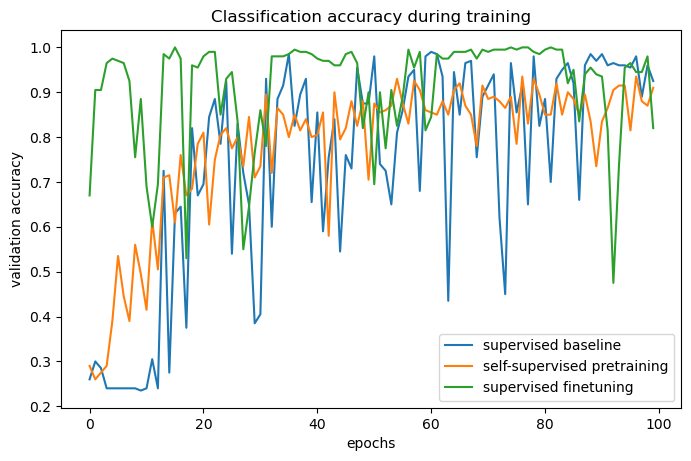

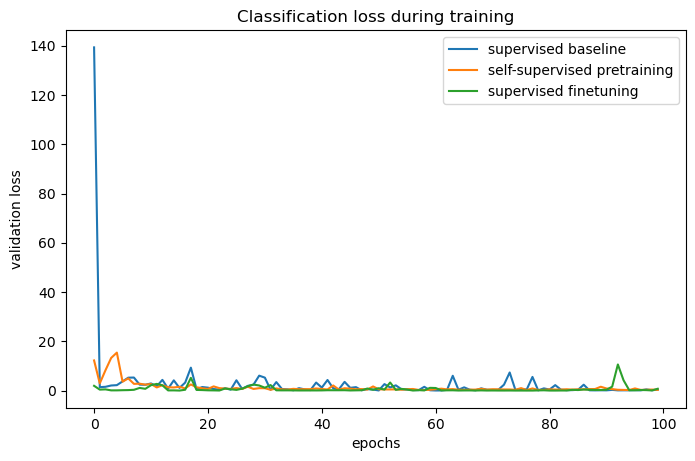

In [13]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

## Save the models

In [14]:
model_dir = './models_all/'
os.mkdir(model_dir)
baseline_model.save(model_dir+'resnet50_100epochs_20k_unlabeled_1k_labeled')
# pretraining_model.save(model_dir+'pretrain_20epochs_20k_unlabeled_1k_labeled')
finetuning_model.save(model_dir+'finetune_100epochs_20k_unlabeled_1k_labeled')
print('did work')

INFO:tensorflow:Assets written to: ./models_all/resnet50_20epochs_20k_unlabeled_1k_labeled/assets


INFO:tensorflow:Assets written to: ./models_all/resnet50_20epochs_20k_unlabeled_1k_labeled/assets


INFO:tensorflow:Assets written to: ./models_all/finetune_20epochs_20k_unlabeled_1k_labeled/assets


INFO:tensorflow:Assets written to: ./models_all/finetune_20epochs_20k_unlabeled_1k_labeled/assets
